## 2D Model

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import torch
from botorch.models import SingleTaskGP, ModelListGP
from botorch.models.fully_bayesian import SaasFullyBayesianSingleTaskGP,SaasPyroModel
from botorch.fit import fit_gpytorch_model
from botorch.fit import fit_fully_bayesian_model_nuts
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition.monte_carlo import qExpectedImprovement, qNoisyExpectedImprovement, qUpperConfidenceBound
from botorch.acquisition.analytic import UpperConfidenceBound, ProbabilityOfImprovement
from botorch.optim import optimize_acqf
from botorch.cross_validation import gen_loo_cv_folds
from botorch.posteriors.gpytorch import GPyTorchPosterior
import math

## Identify and plot the objective function

In [7]:
def F(X1,X2):
    return (1-(X1**2+X2**3))*np.exp(-(X1**2+X2**2)/2)

x1 = np.linspace(-3,3,101)
x2 = np.linspace(-3,3,101)
x1,x2 = np.meshgrid(x1,x2)
y = F(x1,x2)

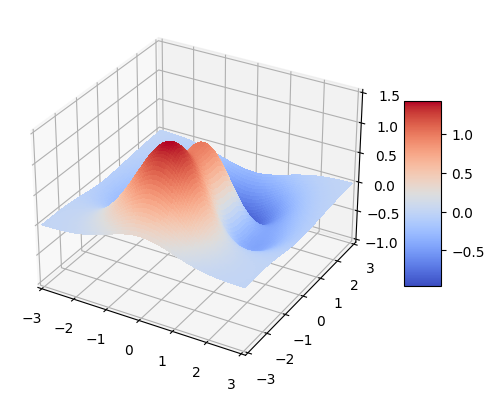

In [8]:
# Plot
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.axes.set_xlim3d(left=-3, right=3)
ax.axes.set_ylim3d(bottom=-3, top=3)
ax.axes.set_zlim3d(bottom=-1, top=1.5)
surf = ax.plot_surface(x1,x2,y, rstride=1, cstride=1,
                      cmap=cm.coolwarm,linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

## Retrive initial dataset

In [9]:
n = 10 # Number of training points
train_x1 = torch.rand(n,1)*3
train_x2 = torch.rand(n,1)*3
train_x = torch.stack((train_x1,train_x2),-1).squeeze(1)

train_y = F(train_x1,train_x2)
best_observed = train_y.max().item()
train_x,train_y,best_observed

(tensor([[0.8919, 1.3272],
         [2.5113, 1.7292],
         [2.7073, 0.5153],
         [2.7519, 2.2666],
         [2.3637, 1.3021],
         [2.1829, 2.2428],
         [1.0198, 1.5897],
         [0.4952, 2.3017],
         [0.3199, 2.7815],
         [1.0700, 1.9392]]),
 tensor([[-0.5940],
         [-0.1004],
         [-0.1450],
         [-0.0317],
         [-0.1782],
         [-0.1123],
         [-0.6818],
         [-0.7157],
         [-0.4094],
         [-0.6400]]),
 -0.03165915235877037)

Visualise training points

/var/folders/dh/dgy1v49j4rs7lcfxbxnn5bzm0000gn/T/ipykernel_30069/1261313872.py:7: UserWarning: The following kwargs were not used by contour: 'rstride', 'cstride', 'linewidth'
  surf = ax.contourf(x1, x2, y, rstride=1, cstride=1,


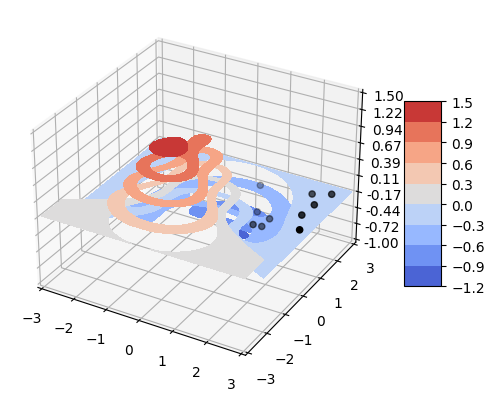

In [11]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.axes.set_xlim3d(left=-3, right=3)
ax.axes.set_ylim3d(bottom=-3, top=3)
ax.axes.set_zlim3d(bottom=-1, top=1.5)

surf = ax.contourf(x1, x2, y, rstride=1, cstride=1,
                      cmap=cm.coolwarm,linewidth=0, antialiased=False) # Objective
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=5)

ax.scatter(train_x1,train_x2,train_y,color='black')

plt.show()

## Fit GP model
Default:
    likelihood: standard Gaussian likelihood with inferred noise level
    Covar_module: Matern kernel
    Mean_module: Constant mean

In [12]:
model = SingleTaskGP(train_x,train_y)
mll = ExactMarginalLogLikelihood(model.likelihood,model)
fit_gpytorch_model(mll)


test_x1 = torch.linspace(0, 10, 101)
test_x2 = torch.linspace(0, 10, 101)
test_x = torch.stack((test_x1,test_x2),-1).squeeze(1)

posterior = model.posterior(test_x)

/Users/yimengjin/Desktop/Thesis/Thesis_Yimeng/venv/lib/python3.9/site-packages/botorch/models/gpytorch.py:113: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(


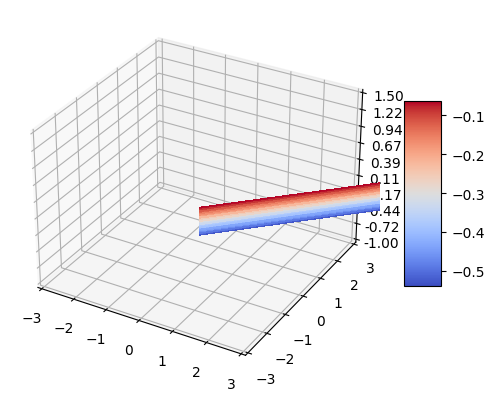

In [13]:
with torch.no_grad():
    # Initialize plot
    fig = plt.figure()
    ax = plt.axes(projection = '3d')
    ax.axes.set_xlim3d(left=-3, right=3)
    ax.axes.set_ylim3d(bottom=-3, top=3)
    ax.axes.set_zlim3d(bottom=-1, top=1.5)
    surf = ax.plot_surface(test_x1,test_x2,posterior.mean, rstride=1, cstride=1,
                          cmap=cm.coolwarm,linewidth=0, antialiased=False) # Posterior.mean is the problem here
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

## Fully Bayesian GP Models (High dimensional problems)
Sample a set of hyperparameters from the posterior
Prior: sparse axis-aligned subspace priors (SAAS) model to identify the most important parameters

In [14]:
# saas_gp = SaasFullyBayesianSingleTaskGP(train_x, train_y)
# fit_fully_bayesian_model_nuts(saas_gp)
# posterior = saas_gp.posterior(test_x)

## Acquistion function
Morte-Carlo sampling:
1. Sampling joint posterior over q points
2. evaluate the current best for each sample
3. maximise over q
4. average over the samples

# EI Defaults:
1. Sampler: SobolQMCNormalSampler
2. Objective: IdentityMCObjective() (objective under which samples is evaluated)

In [15]:
EI = qExpectedImprovement(
    model = model,
    best_f = best_observed
)

## Noisy Expected Improvement:
Does not assume best_f, compute improvement over the previous points and average

In [16]:
NEI = qNoisyExpectedImprovement(
    model = model,
    X_baseline = train_x,
    prune_baseline= True,
)

## qUCB
beta: control the tradeoff between mean and variance.

In [17]:
UCB = qUpperConfidenceBound(
    model = model,
    beta = 0.6,
)

## Optimise acquisition function

In [23]:
candidates_x,_ = optimize_acqf(
    acq_function = EI,
    bounds = torch.tensor([[-3.0] * 2, [3.0] * 2]),
    q = 10, # Number of suggested candidates
    num_restarts = 200,
    raw_samples = 512
)
candidates_x

candidates_x

tensor([[-0.8488,  3.0000],
        [ 0.7744, -3.0000],
        [-3.0000,  3.0000],
        [ 3.0000, -0.6106],
        [-1.6387, -3.0000],
        [ 3.0000,  1.4451],
        [ 1.9693, -0.1367],
        [-3.0000, -3.0000],
        [ 2.5722,  3.0000],
        [-2.5193,  0.1879]])

In [24]:
candidates_x1 = candidates_x[:,0]
candidates_x2 = candidates_x[:,1]
candidates_x1,candidates_x2

(tensor([-0.8488,  0.7744, -3.0000,  3.0000, -1.6387,  3.0000,  1.9693, -3.0000,
          2.5722, -2.5193]),
 tensor([ 3.0000, -3.0000,  3.0000, -0.6106, -3.0000,  1.4451, -0.1367, -3.0000,
          3.0000,  0.1879]))

In [25]:
candidates_y = F(candidates_x1,candidates_x2).unsqueeze(-1)
candidates_y

tensor([[-0.2071],
        [ 0.2255],
        [-0.0043],
        [-0.0717],
        [ 0.0734],
        [-0.0431],
        [-0.4098],
        [ 0.0023],
        [-0.0133],
        [-0.2202]])

Visualise suggested candidates

/var/folders/dh/dgy1v49j4rs7lcfxbxnn5bzm0000gn/T/ipykernel_30069/1849393821.py:7: UserWarning: The following kwargs were not used by contour: 'rstride', 'cstride', 'linewidth'
  surf = ax.contourf3D(x1, x2, y, rstride=1, cstride=1,


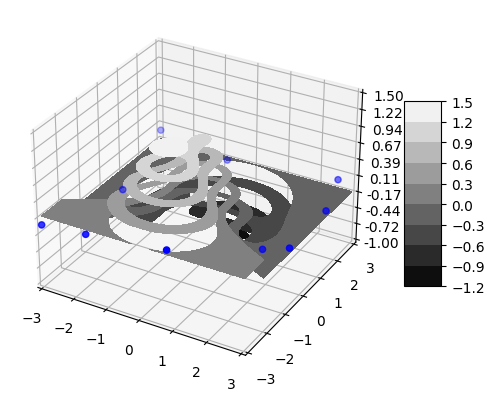

In [26]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.axes.set_xlim3d(left=-3, right=3)
ax.axes.set_ylim3d(bottom=-3, top=3)
ax.axes.set_zlim3d(bottom=-1, top=1.5)

surf = ax.contourf3D(x1, x2, y, rstride=1, cstride=1,
                      cmap=cm.gray,linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=5)

ax.scatter(candidates_x1,candidates_x2,candidates_y,color='blue')

plt.show()

In [27]:
# plt.plot(train_x,train_y,'o', color = 'black')
# plt.plot(candidates_x,candidates_y,'*')
# plt.legend(['training points','suggested candidates'])
# plt.plot(x,F(x))
# plt.show()

## Take in suggested data, forming new training dataset

In [28]:
combine_x = (train_x,candidates_x)
combine_y = (train_y,candidates_y)
posterior_x = torch.cat(combine_x, dim = 0)
posterior_y = torch.cat(combine_y, dim = 0)
posterior_x,posterior_y

(tensor([[ 0.8919,  1.3272],
         [ 2.5113,  1.7292],
         [ 2.7073,  0.5153],
         [ 2.7519,  2.2666],
         [ 2.3637,  1.3021],
         [ 2.1829,  2.2428],
         [ 1.0198,  1.5897],
         [ 0.4952,  2.3017],
         [ 0.3199,  2.7815],
         [ 1.0700,  1.9392],
         [-0.8488,  3.0000],
         [ 0.7744, -3.0000],
         [-3.0000,  3.0000],
         [ 3.0000, -0.6106],
         [-1.6387, -3.0000],
         [ 3.0000,  1.4451],
         [ 1.9693, -0.1367],
         [-3.0000, -3.0000],
         [ 2.5722,  3.0000],
         [-2.5193,  0.1879]]),
 tensor([[-0.5940],
         [-0.1004],
         [-0.1450],
         [-0.0317],
         [-0.1782],
         [-0.1123],
         [-0.6818],
         [-0.7157],
         [-0.4094],
         [-0.6400],
         [-0.2071],
         [ 0.2255],
         [-0.0043],
         [-0.0717],
         [ 0.0734],
         [-0.0431],
         [-0.4098],
         [ 0.0023],
         [-0.0133],
         [-0.2202]]))

## Posterior model (Not sure how to plot contour yet)

In [29]:
posterior_model = SingleTaskGP(posterior_x,posterior_y,)
mll = ExactMarginalLogLikelihood(posterior_model.likelihood,model)
fit_gpytorch_model(mll)

/Users/yimengjin/Desktop/Thesis/Thesis_Yimeng/venv/lib/python3.9/site-packages/botorch/models/gpytorch.py:113: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(


ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
        (distance_module): Distance()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
  )
)

In [30]:
# # Plot
# posterior_model.eval()
# # Initialize plot
# f, ax = plt.subplots(1, 1, figsize=(6, 4))
# # test model on 101 regular spaced points on the interval [0, 10]
# test_x = torch.linspace(0, 10, 101)
# # no need for gradients
# with torch.no_grad():
#     # compute posterior
#     posterior = posterior_model.posterior(test_x)
#     # Get upper and lower confidence bounds (2 standard deviations from the mean)
#     lower, upper = posterior.mvn.confidence_region()
#     # Plot training points as black stars
#     ax.plot(posterior_x.cpu().numpy(), posterior_y.cpu().numpy(), 'o',)
#     # Plot posterior means as blue line
#     ax.plot(test_x.cpu().numpy(), posterior.mean.cpu().numpy(), 'b')
#     # Shade between the lower and upper confidence bounds
#     ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
#     plt.plot(x,F(x))
# ax.legend(['Observed Data', 'Mean', 'Confidence'])
# plt.tight_layout()
# plt.show()

## Second run

In [31]:
EI = qExpectedImprovement(
    model = posterior_model,
    best_f = best_observed
)

In [32]:
candidates_x,_ = optimize_acqf(
    acq_function = EI,
    bounds = torch.tensor([[-3.0] * 2, [3.0] * 2]),
    q = 10, # Number of suggested candidates
    num_restarts = 200,
    raw_samples = 512
)
candidates_x

tensor([[ 0.0846, -1.7997],
        [ 1.3043, -1.9648],
        [-1.3129,  1.2521],
        [-3.0000,  1.6706],
        [-0.5618, -0.1279],
        [ 1.9058, -3.0000],
        [-1.4013, -1.6155],
        [-3.0000, -1.5236],
        [ 3.0000, -2.2472],
        [-0.3092, -3.0000]])

In [33]:
candidates_x1 = candidates_x[:,0]
candidates_x2 = candidates_x[:,1]
candidates_x1,candidates_x2

(tensor([ 0.0846,  1.3043, -1.3129, -3.0000, -0.5618,  1.9058, -1.4013, -3.0000,
          3.0000, -0.3092]),
 tensor([-1.7997, -1.9648,  1.2521,  1.6706, -0.1279, -3.0000, -1.6155, -1.5236,
         -2.2472, -3.0000]))

In [34]:
candidates_y = F(candidates_x1,candidates_x2).unsqueeze(-1)
candidates_y

tensor([[ 1.3460],
        [ 0.4267],
        [-0.5182],
        [-0.0348],
        [ 0.5815],
        [ 0.0440],
        [ 0.3304],
        [-0.0155],
        [ 0.0030],
        [ 0.2955]])

/var/folders/dh/dgy1v49j4rs7lcfxbxnn5bzm0000gn/T/ipykernel_30069/1849393821.py:7: UserWarning: The following kwargs were not used by contour: 'rstride', 'cstride', 'linewidth'
  surf = ax.contourf3D(x1, x2, y, rstride=1, cstride=1,


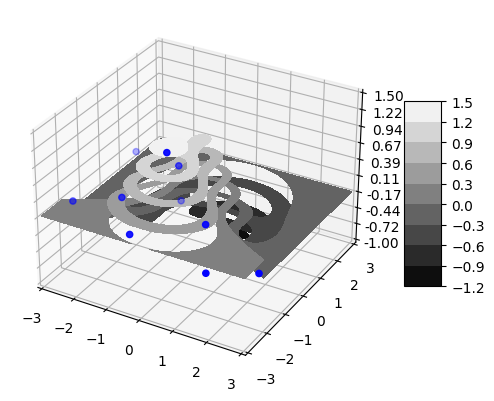

In [35]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.axes.set_xlim3d(left=-3, right=3)
ax.axes.set_ylim3d(bottom=-3, top=3)
ax.axes.set_zlim3d(bottom=-1, top=1.5)

surf = ax.contourf3D(x1, x2, y, rstride=1, cstride=1,
                      cmap=cm.gray,linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=5)

ax.scatter(candidates_x1,candidates_x2,candidates_y,color='blue')

plt.show()